# Challenge Temperature data
## List of Files
|File Name| Description|
|:---|:---|
|CHAL-4_TempRemoved_nodate_nospikeTemperature&SysData.xlsx|Challenge data file with temperatures removed–insert challenge  results here.|
|Temperature_Challenge_Sample_Model_Locations.xlsx|Template to input optional additional temperature simulated results–challenge.|

### CHAL-4_TempRemoved_nodate_nospikeTemperature&SysData.xlsx
The challenge temperature data file is provided in CHAL-4_TempRemoved_nodate_nospikeTemperature&SysData.xlsx.
The format for this file is identical to SRP-4_nospike_Temperature&SysData.xlsx, with the temperature data from Thermocouple 1-11 left empty, to be filled by the participant.
The thermocouple locations are visualized in figure 2.8 of the challenge_info_packet, and formally specified in Thermocouple.SLDPRT. 
Timestamps, Thermocouple 12 (ambient) temperature data, Weld Voltage, Weld Current, Weld on, and print head positions are all provided. 


- ***Column 1, Timestamp:*** Timestamp data formatted as \<hour\>:\<minute\>:\<second\>.
- ***Columns 2-13, Thermocouple \<number\>:***. Left empty, to be filled by the participant and returned. 
- ***Column 13, Thermocouple 12:***. Continuous data, temperature measurements in celsius for the ambient thermocouple.
- ***Column 14, Weld Voltage:*** Continuous data, measured in V (volts)
- ***Column 15, Weld Current:*** Continuous data, Measured in A (amperes)
- ***Column 16, Weld on:*** Binary data, indicates whether the power is on or off, 1 for on and 0 for off. 
- ***Column 17-19, \<axis\> Position:*** Continuous data, print head locations (X, Y, Z) in mm. The origin is located in the center of the part.

# Reading and Visualizing the Data

As we did for the calibration data, we visualize the columns provided for the challenge data. 

In [1]:
import pandas as pd
import dateutil
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.dates as mdates

Tmp_npspike = pd.read_excel('CHAL-4_TempRemoved_nodate_nospikeTemperature&SysData.xlsx', skiprows=5)
times = np.array(Tmp_npspike)[:,0].astype(str)
t = [dateutil.parser.parse(s) for s in times]

## Weld on, weld off behavior.

We provide a simple visualization of the weld on/weld off behavior against the single thermocouple provided. 
Note that the weld off states for each layer include an intermediate weld-off state for positioning around the challenge curl bar's interior hole. 

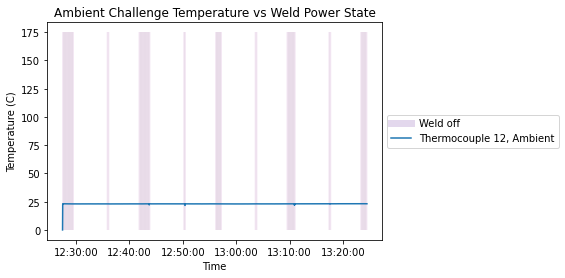

In [2]:
weld_off = [t[i] for i in np.where(Tmp_npspike['Weld On'] == 0)[0]]

plt.vlines(weld_off, 0, 175, alpha=.01, color='tab:purple')
plt.plot([], [], color='tab:purple', linewidth='7', alpha=.25, label='Weld off')
plt.plot(t, Tmp_npspike['Thermocouple 12'], label='Thermocouple 12, Ambient')

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.ylabel('Temperature (C)')
plt.xlabel('Time')
ax=plt.gca()
xfmt = mdates.DateFormatter('%H:%M:%S')
ax.xaxis.set_major_formatter(xfmt)
plt.title('Ambient Challenge Temperature vs Weld Power State')
plt.show()

## Power behavior

Here we visualize the power data, which was logged indirectly via the voltage and current (columns 14 and 15, respectively, of CHAL-4_TempRemoved_nodate_nospikeTemperature&SysData.xlsx). 
The setup problem assumes constant power when the weld is on: the average nonzero power is approximately 2589.1413 (note this is about 10 Watts lower than the average power for the calibration weld on state). 

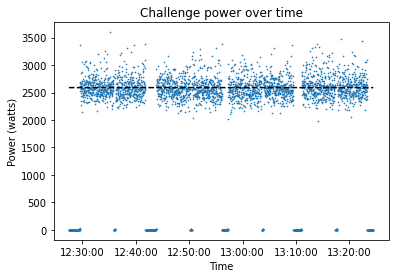

In [3]:
Power = np.array(Tmp_npspike['Weld Voltage'] * Tmp_npspike['Weld Current'])

#plt.plot(t, Power)
plt.scatter(t, Power, s=.4)
plt.plot(t, np.ones_like(t)*Power[Power > 500].mean(), 'k--')
xfmt = mdates.DateFormatter('%H:%M:%S')
ax=plt.gca()
ax.xaxis.set_major_formatter(xfmt)
plt.title("Challenge power over time")
plt.xlabel('Time')
plt.ylabel('Power (watts)')
plt.show()

## Print Head Position

We include an animation of the challenge print head position over time.
As before, we indicate the weld on/weld off state via the background color (dark for off, light for on). 
This data is provided in columns 17-19 of CHAL-4_TempRemoved_nodate_nospikeTemperature&SysData.xlsx. 

This animation visualizes two key differences between the challenge and calibration problems. 
First, the print pattern follows the short end of the challenge curl bar, rather than the length. 
Second, a small hole is left in the center of the challenge curl bar, resulting in an intermediate weld off period for each layer. 

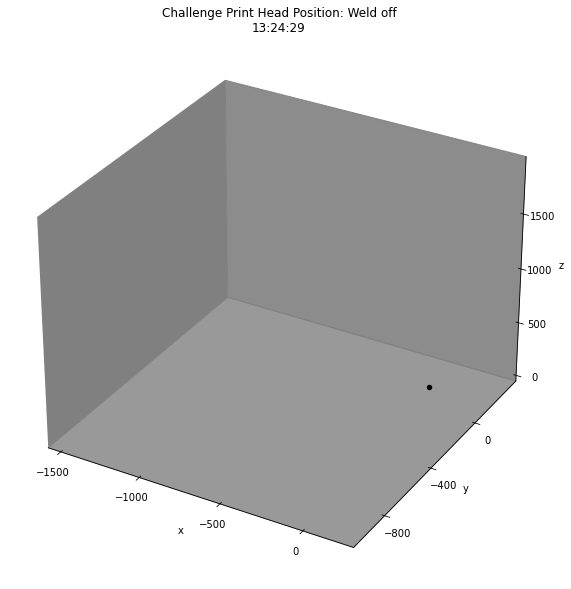

In [4]:
import matplotlib.ticker as ticker
import mpl_toolkits.mplot3d.axes3d as p3
import matplotlib.animation as animation
from IPython.display import HTML

XYZ = np.array(Tmp_npspike[['X Position', 'Y Position', 'Z Position']])

fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')
xlim = (np.min(XYZ[:,0])-10, np.max(XYZ[:,0])+10)
ylim = (np.min(XYZ[:,1])-10, np.max(XYZ[:,1])+10)
zlim = (np.min(XYZ[:,2])-10, np.max(XYZ[:,2])+10)

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.set_zlim(zlim)
ax.grid(False)

timestamp_str = np.array(Tmp_npspike['Timestamp'], dtype=str)
scatter_frame = ax.scatter3D([],[],[], c='k')
weldstat = 'Weld off'
title = ax.set_title('Challenge Print Head Position: '+ weldstat)

ax.w_xaxis.set_pane_color((0.5,.5,.5,1))
ax.w_yaxis.set_pane_color((0.5,.5,.5,.9))
ax.w_zaxis.set_pane_color((0.5,.5,.5,.8))

ax.xaxis.set_major_locator(ticker.MaxNLocator(4))
ax.yaxis.set_major_locator(ticker.MaxNLocator(4))
ax.zaxis.set_major_locator(ticker.MaxNLocator(4))

def drawframe(i):
    scatter_frame._offsets3d = (XYZ[i,0:1], XYZ[i,1:2], XYZ[i,2:])
    title.set_text('Print Head Position\n' + str(timestamp_str[i]))
    if Tmp_npspike['Weld On'][i] == 0:
        weldstat = 'Weld off'
    else:
        weldstat = 'Weld on'
    if i > 1:
        if (Tmp_npspike['Weld On'][i] == 0) and (Tmp_npspike['Weld On'][i-1] == 1):
            ax.w_xaxis.set_pane_color((0.5,.5,.5,1))
            ax.w_yaxis.set_pane_color((0.5,.5,.5,.9))
            ax.w_zaxis.set_pane_color((0.5,.5,.5,.8))

        if (Tmp_npspike['Weld On'][i] == 1) and (Tmp_npspike['Weld On'][i-1] == 0):
            ax.w_xaxis.set_pane_color((.8,.8,.8,1))
            ax.w_yaxis.set_pane_color((.8,.8,.8,.9))
            ax.w_zaxis.set_pane_color((.8,.8,.8,.8))
    
    title.set_text('Challenge Print Head Position: ' + weldstat + '\n' + str(timestamp_str[i]))
    
    return(scatter_frame, title)

anim = animation.FuncAnimation(fig, drawframe, XYZ.shape[0], repeat=False, interval=100)#XYZ.shape[0])

Writer1 = animation.writers['ffmpeg']
writer = Writer1(fps=30, metadata=dict(artist='Me'), bitrate=1800, extra_args=['-vcodec', 'libx264'])
anim.save('Chall Print_Head_Pos.mp4', writer=writer)

HTML(anim.to_html5_video())
